# Proyecto 1.b - Análisis de Grafos de Conectividad

**parte 1 . Análisis Exploratorio de Datos (EDA)**:

Carga e Inspección de Datos, Visualización, Exploración de Señales EEG, Exploración de Señales de Audio, Estadísticas Descriptivas


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from IPython.display import Audio, display

np.random.seed(42)

DATA_DIR = Path("data")
SLOW_DIR = DATA_DIR / "slow"
FAST_DIR = DATA_DIR / "fast"

TOTAL_ELECTRODES = 65
GOOD_ELECTRODES_MATLAB = [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 38, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 65]
GOOD_ELECTRODES_PY = [x - 1 for x in GOOD_ELECTRODES_MATLAB]
N_GOOD_ELECTRODES = len(GOOD_ELECTRODES_PY)

print(f"Directorio de datos: {DATA_DIR}")
print(f"Total de electrodos: {TOTAL_ELECTRODES}")
print(f"Electrodos buenos: {N_GOOD_ELECTRODES}")
slow_files = sorted(list(SLOW_DIR.glob("*.mat")))
fast_files = sorted(list(FAST_DIR.glob("*.mat")))

print(f"Archivos audio lento: {len(slow_files)}")
print(f"Archivos audio rápido: {len(fast_files)}")
print(f"Total: {len(slow_files) + len(fast_files)}")


sample_slow_file = slow_files[0]
sample_fast_file = fast_files[0]

data_slow = loadmat(sample_slow_file)
data_fast = loadmat(sample_fast_file)

print("ARCHIVO LENTO:")
for key in data_slow.keys():
    if not key.startswith("__"):
        print(f"  {key}: shape {data_slow[key].shape}")

print("\nARCHIVO RÁPIDO:")
for key in data_fast.keys():
    if not key.startswith("__"):
        print(f"  {key}: shape {data_fast[key].shape}")

Directorio de datos: data
Total de electrodos: 65
Electrodos buenos: 47
Archivos audio lento: 710
Archivos audio rápido: 706
Total: 1416
ARCHIVO LENTO:
  Fs: shape (1, 1)
  subeeg: shape (4606, 65)
  y: shape (812543, 2)

ARCHIVO RÁPIDO:
  Fs: shape (1, 1)
  subeeg: shape (2879, 65)
  y: shape (507839, 2)


In [2]:
def resumen_archivo(data):
    eeg = data["subeeg"]
    audio = data["y"]
    fs_audio = int(data["Fs"][0, 0])
    dur_audio = audio.shape[0] / fs_audio
    fs_eeg = eeg.shape[0] / dur_audio
    return {
        "EEG forma": eeg.shape,
        "Audio forma": audio.shape,
        "Fs audio (Hz)": fs_audio,
        "Duración (s)": dur_audio,
        "Fs EEG (Hz)": fs_eeg,
    }, eeg, audio, fs_audio, fs_eeg

res_slow, eeg_slow, audio_slow, fs_audio, fs_eeg = resumen_archivo(data_slow)
res_fast, eeg_fast, audio_fast, fs_audio_fast, fs_eeg_fast = resumen_archivo(data_fast)

Fs_audio = fs_audio
Fs_eeg = int(round(fs_eeg))

resumen_df = pd.DataFrame([
    {"Condición": "Lenta", **res_slow},
    {"Condición": "Rápida", **res_fast},
]).set_index("Condición").round(2)

display(resumen_df)

EEG forma  Audio forma  Fs audio (Hz)  Duración (s)  Fs EEG (Hz)
Condición                                                                   
Lenta      (4606, 65)  (812543, 2)          44100         18.43       249.99
Rápida     (2879, 65)  (507839, 2)          44100         11.52       250.01

eeg_slow.shape = (4606, 65)
Esperado: (65, n_muestras) donde n_muestras >> 65
Transponiendo datos...
Nueva forma: (65, 4606)
EEG original: (65, 4606)
EEG buenos electrodos: (47, 4606)
Removidos: 18 electrodos

EEG Lento:
  NaN: 0
  Min: -130.090424, Max: 126.534592
  Media: -0.000000, Std: 28.551680

EEG Rápido:
  NaN: 0
  Min: -134.882385, Max: 112.794121
  Media: 0.000000, Std: 27.814211

Audio Lento:
  NaN: 0
  Min: -0.953674, Max: 0.854736
  Media: 0.000000, Std: 0.096133

Audio Rápido:
  NaN: 0
  Min: -0.897186, Max: 0.793427
  Media: 0.000005, Std: 0.082441


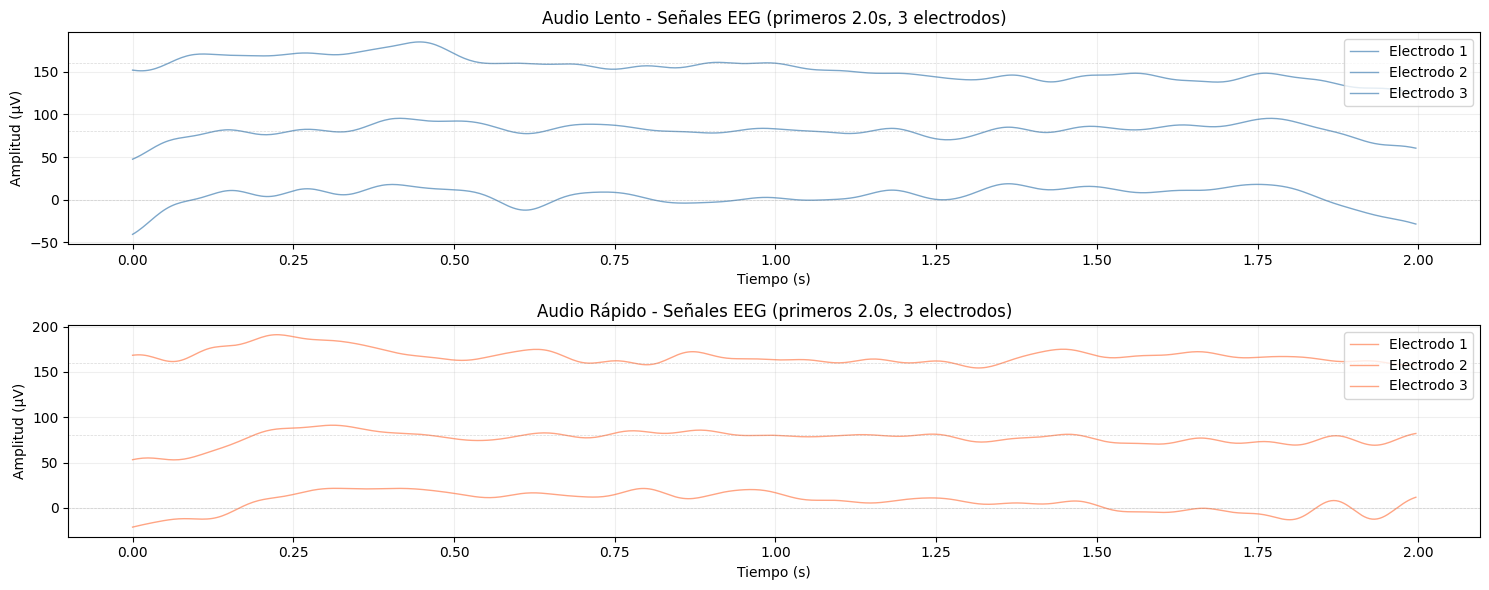

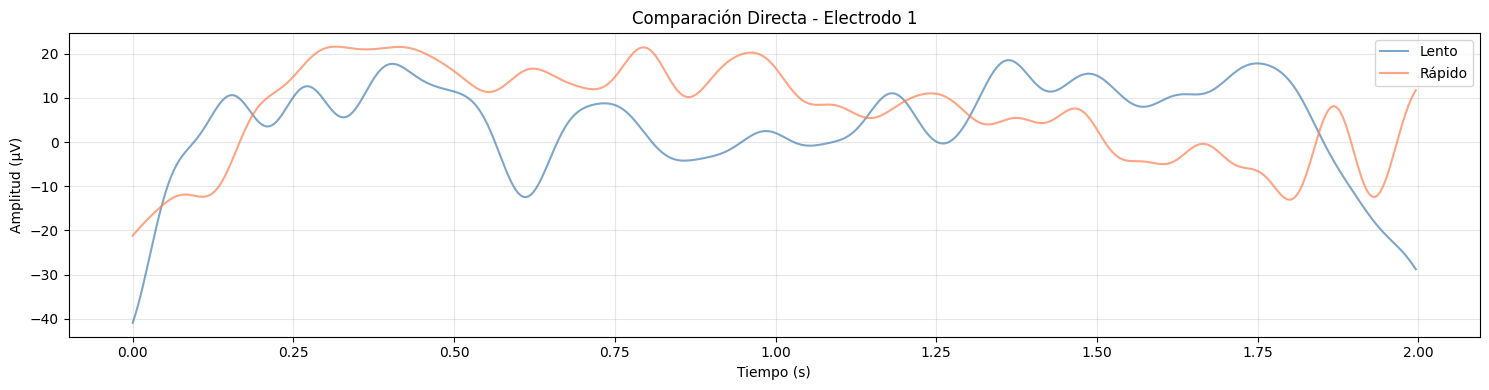

In [3]:
print(f"eeg_slow.shape = {eeg_slow.shape}")
print(f"Esperado: (65, n_muestras) donde n_muestras >> 65")

if eeg_slow.shape[0] > eeg_slow.shape[1]:
    print("Transponiendo datos...")
    eeg_slow = eeg_slow.T
    eeg_fast = eeg_fast.T
    print(f"Nueva forma: {eeg_slow.shape}")
else:
    print("Orientación correcta")

eeg_slow_good = eeg_slow[GOOD_ELECTRODES_PY, :]
eeg_fast_good = eeg_fast[GOOD_ELECTRODES_PY, :]

print(f"EEG original: {eeg_slow.shape}")
print(f"EEG buenos electrodos: {eeg_slow_good.shape}")
print(f"Removidos: {eeg_slow.shape[0] - eeg_slow_good.shape[0]} electrodos")

def check_calidad(data, nombre):
    print(f"\n{nombre}:")
    print(f"  NaN: {np.isnan(data).sum()}")
    print(f"  Min: {np.min(data):.6f}, Max: {np.max(data):.6f}")
    print(f"  Media: {np.mean(data):.6f}, Std: {np.std(data):.6f}")

check_calidad(eeg_slow_good, "EEG Lento")
check_calidad(eeg_fast_good, "EEG Rápido")
check_calidad(audio_slow, "Audio Lento")
check_calidad(audio_fast, "Audio Rápido")

duration_plot = 2  # Reducir a 2 segundos para ver mejor el detalle
n_channels_plot = 3  # Reducir a 3 electrodos

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

def plot_eeg(ax, data, titulo, fs, color='blue'):
    samples = min(int(duration_plot * fs), data.shape[1])
    time = np.arange(samples) / fs
    
    for i in range(n_channels_plot):
        offset = i * 80
        ax.plot(time, data[i, :samples] + offset, label=f"Electrodo {i + 1}", 
                color=color, alpha=0.7, linewidth=1)
        ax.axhline(y=offset, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
    
    ax.set_title(f"{titulo} (primeros {samples / fs:.1f}s, {n_channels_plot} electrodos)")
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Amplitud (μV)")
    ax.legend(loc='upper right')
    ax.grid(alpha=0.2)

plot_eeg(axes[0], eeg_slow_good, "Audio Lento - Señales EEG", Fs_eeg, 'steelblue')
plot_eeg(axes[1], eeg_fast_good, "Audio Rápido - Señales EEG", Fs_eeg, 'coral')

plt.tight_layout()
plt.show()

# Comparación de un solo electrodo superpuesto
fig, ax = plt.subplots(figsize=(15, 4))
electrode_compare = 0
samples = min(int(duration_plot * Fs_eeg), eeg_slow_good.shape[1], eeg_fast_good.shape[1])
time = np.arange(samples) / Fs_eeg

ax.plot(time, eeg_slow_good[electrode_compare, :samples], 
        label='Lento', color='steelblue', alpha=0.7, linewidth=1.5)
ax.plot(time, eeg_fast_good[electrode_compare, :samples], 
        label='Rápido', color='coral', alpha=0.7, linewidth=1.5)
ax.set_title(f"Comparación Directa - Electrodo {electrode_compare + 1}")
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud (μV)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Reproducción y Comparación de Audios


Audio Lento (velocidad normal):



Audio Rápido (acelerado):


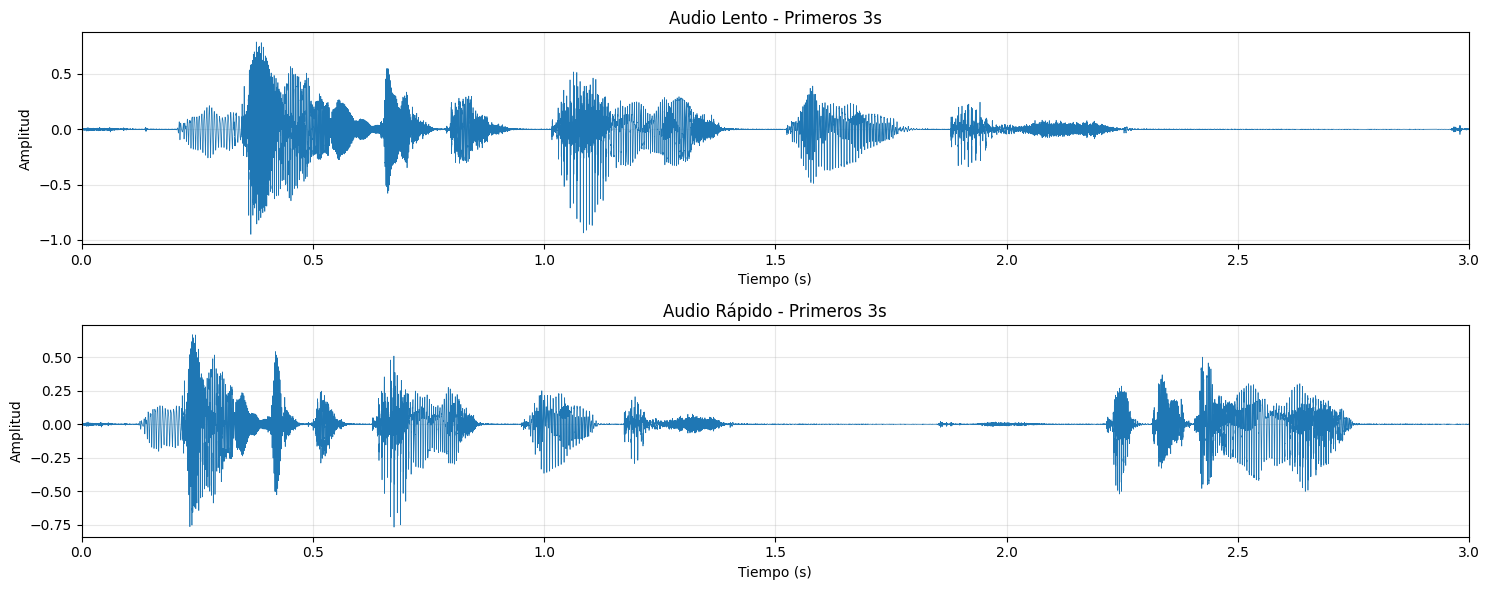


Duración total audio lento: 18.43 s
Duración total audio rápido: 11.52 s


In [4]:


# Reproducir audio lento
print("Audio Lento (velocidad normal):")
display(Audio(audio_slow[:, 0], rate=Fs_audio))

print("\nAudio Rápido (acelerado):")
display(Audio(audio_fast[:, 0], rate=Fs_audio))

# Visualización de forma de onda (primeros 3 segundos)
duration_to_plot = 3
samples_slow = int(duration_to_plot * Fs_audio)
samples_fast = int(duration_to_plot * Fs_audio)

time_slow = np.arange(samples_slow) / Fs_audio
time_fast = np.arange(samples_fast) / Fs_audio

audio_slow_mono = audio_slow[:, 0] if audio_slow.ndim > 1 else audio_slow
audio_fast_mono = audio_fast[:, 0] if audio_fast.ndim > 1 else audio_fast

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].plot(time_slow, audio_slow_mono[:samples_slow], linewidth=0.5)
axes[0].set_title(f"Audio Lento - Primeros {duration_to_plot}s")
axes[0].set_xlabel("Tiempo (s)")
axes[0].set_ylabel("Amplitud")
axes[0].set_xlim(0, duration_to_plot)
axes[0].grid(alpha=0.3)

axes[1].plot(time_fast, audio_fast_mono[:samples_fast], linewidth=0.5)
axes[1].set_title(f"Audio Rápido - Primeros {duration_to_plot}s")
axes[1].set_xlabel("Tiempo (s)")
axes[1].set_ylabel("Amplitud")
axes[1].set_xlim(0, duration_to_plot)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDuración total audio lento: {len(audio_slow) / Fs_audio:.2f} s")
print(f"Duración total audio rápido: {len(audio_fast) / Fs_audio:.2f} s")

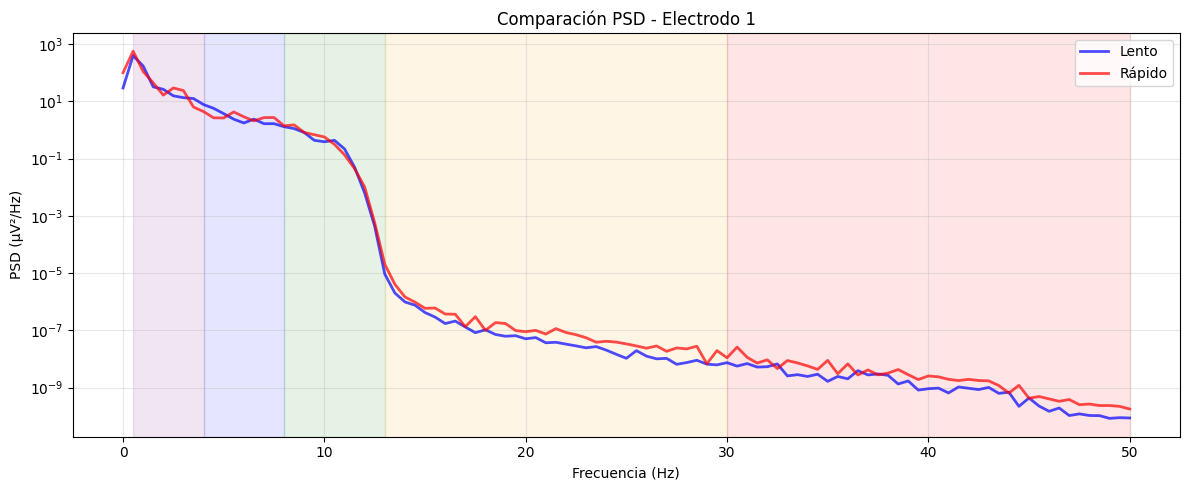

In [5]:
from scipy import signal

electrode_idx = 0

freqs_slow, psd_slow = signal.welch(
    eeg_slow_good[electrode_idx, :],
    fs=Fs_eeg,
    nperseg=min(2 * Fs_eeg, eeg_slow_good.shape[1])
)

freqs_fast, psd_fast = signal.welch(
    eeg_fast_good[electrode_idx, :],
    fs=Fs_eeg,
    nperseg=min(2 * Fs_eeg, eeg_fast_good.shape[1])
)

fig, ax = plt.subplots(figsize=(12, 5))
freq_mask = freqs_slow <= 50

# Bandas de frecuencia
bandas = [
    (0.5, 4, "purple", "Delta"),
    (4, 8, "blue", "Theta"),
    (8, 13, "green", "Alpha"),
    (13, 30, "orange", "Beta"),
    (30, 50, "red", "Gamma")
]

for inicio, fin, color, nombre in bandas:
    ax.axvspan(inicio, fin, alpha=0.1, color=color)

ax.semilogy(freqs_slow[freq_mask], psd_slow[freq_mask], 'b-', linewidth=2, label='Lento', alpha=0.7)
ax.semilogy(freqs_fast[freq_mask], psd_fast[freq_mask], 'r-', linewidth=2, label='Rápido', alpha=0.7)
ax.set_title(f"Comparación PSD - Electrodo {electrode_idx+1}")
ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("PSD (μV²/Hz)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

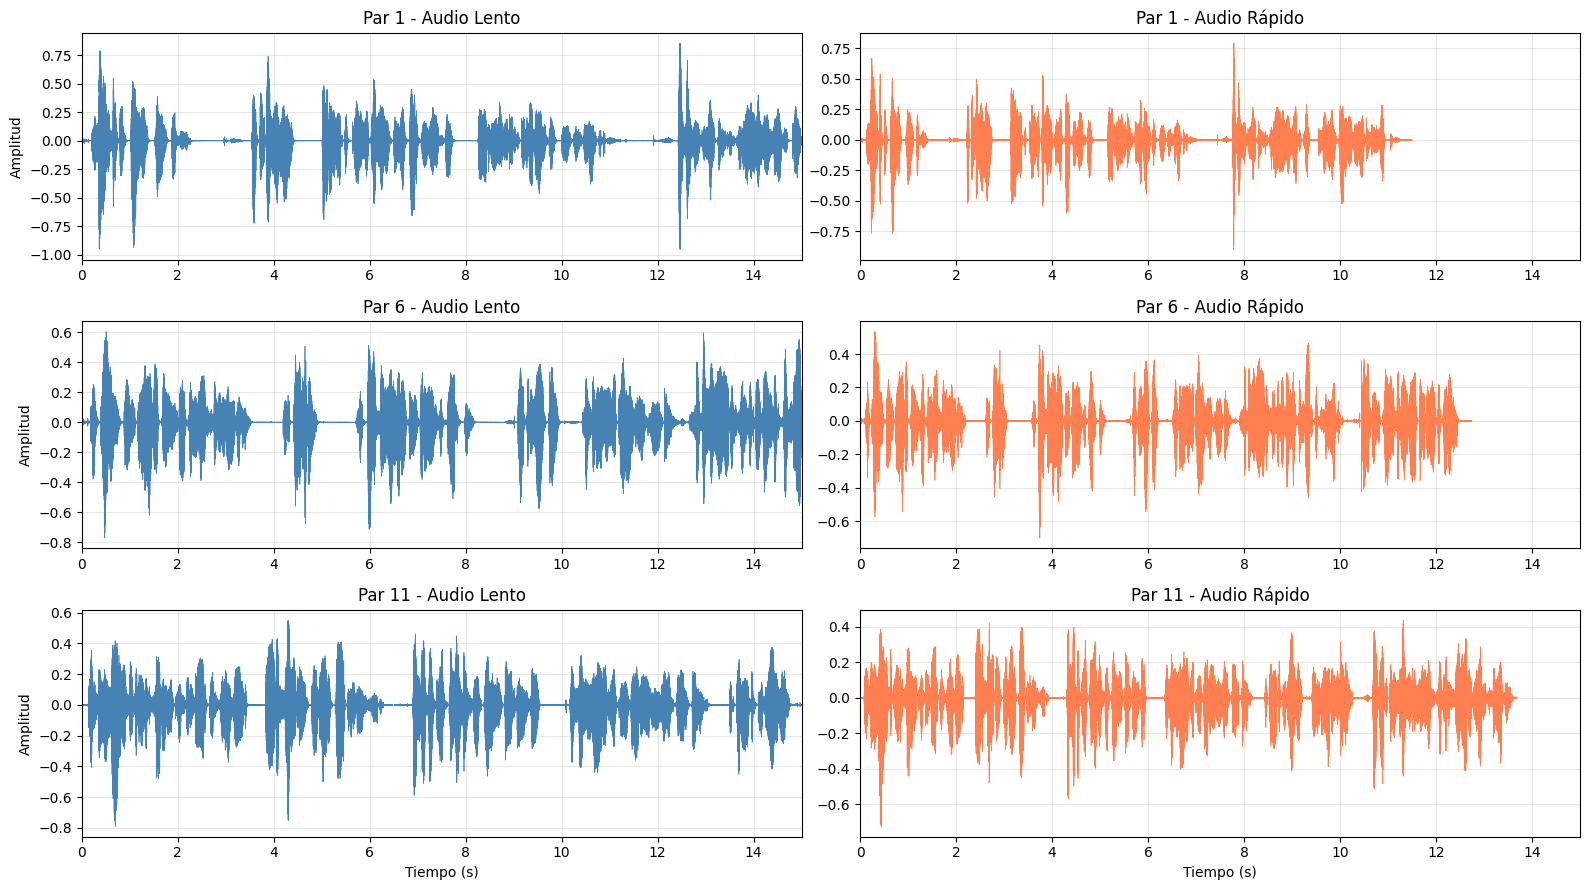

Cada fila muestra un par diferente de audio (slow-fast del mismo contenido)


In [6]:
# Comparar 3 pares diferentes de audios slow-fast
n_pairs = 3
pair_indices = [0, 5, 10]

fig, axes = plt.subplots(n_pairs, 2, figsize=(16, 3*n_pairs))

for idx, pair_idx in enumerate(pair_indices):
    # Cargar par slow-fast
    data_s = loadmat(slow_files[pair_idx])
    data_f = loadmat(fast_files[pair_idx])
    
    audio_s = data_s["y"][:, 0] if data_s["y"].ndim > 1 else data_s["y"]
    audio_f = data_f["y"][:, 0] if data_f["y"].ndim > 1 else data_f["y"]
   
    dur = 15  # Duración a graficar en segundos
    samples_s = min(int(dur * Fs_audio), len(audio_s))
    samples_f = min(int(dur * Fs_audio), len(audio_f))
    
    time_s = np.arange(samples_s) / Fs_audio
    time_f = np.arange(samples_f) / Fs_audio
    
    axes[idx, 0].plot(time_s, audio_s[:samples_s], linewidth=0.5, color='steelblue')
    axes[idx, 0].set_title(f"Par {pair_idx+1} - Audio Lento")
    axes[idx, 0].set_ylabel("Amplitud")
    axes[idx, 0].set_xlim(0, dur)
    axes[idx, 0].grid(alpha=0.3)
    
    axes[idx, 1].plot(time_f, audio_f[:samples_f], linewidth=0.5, color='coral')
    axes[idx, 1].set_title(f"Par {pair_idx+1} - Audio Rápido")
    axes[idx, 1].set_xlim(0, dur)
    axes[idx, 1].grid(alpha=0.3)
    
    if idx == n_pairs - 1:
        axes[idx, 0].set_xlabel("Tiempo (s)")
        axes[idx, 1].set_xlabel("Tiempo (s)")

plt.tight_layout()
plt.show()

print("Cada fila muestra un par diferente de audio (slow-fast del mismo contenido)")

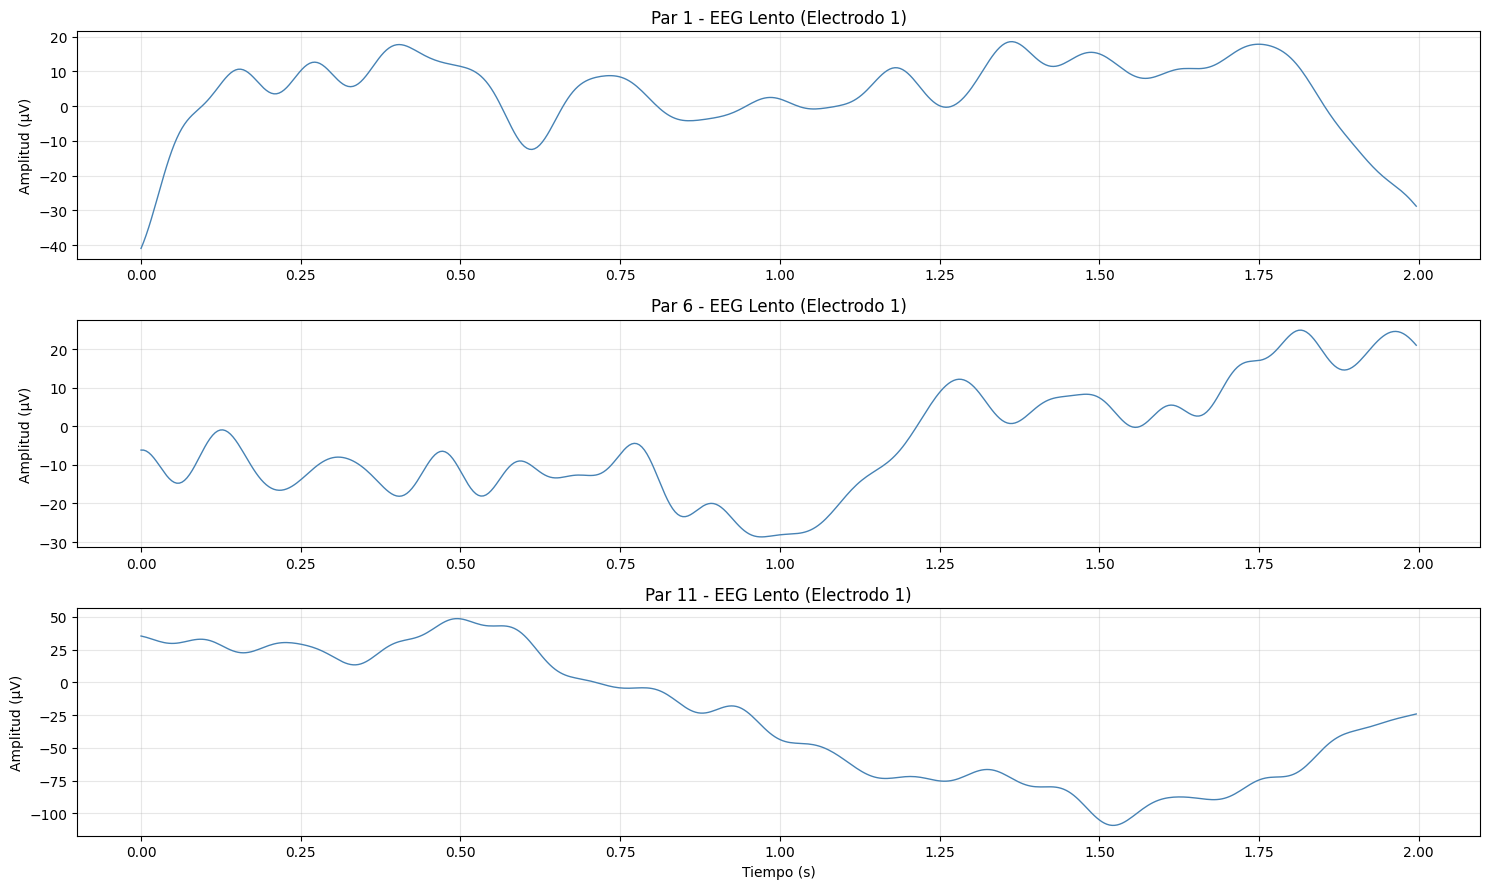

Cada gráfico muestra la señal EEG de un par diferente de audio (condición lenta)


In [7]:
# Comparar señales EEG de 3 pares diferentes (slow)
n_pairs_eeg = 3
pair_indices_eeg = [0, 5, 10]
electrode_to_plot = 0
dur_eeg = 2

fig, axes = plt.subplots(n_pairs_eeg, 1, figsize=(15, 3*n_pairs_eeg))

for idx, pair_idx in enumerate(pair_indices_eeg):
    # Cargar datos
    data_s = loadmat(slow_files[pair_idx])
    eeg_data = data_s["subeeg"]
    
    # Transponer si es necesario
    if eeg_data.shape[0] > eeg_data.shape[1]:
        eeg_data = eeg_data.T
    
    # Seleccionar buenos electrodos
    eeg_good = eeg_data[GOOD_ELECTRODES_PY, :]
    
    # Graficar
    samples = min(int(dur_eeg * Fs_eeg), eeg_good.shape[1])
    time = np.arange(samples) / Fs_eeg
    
    axes[idx].plot(time, eeg_good[electrode_to_plot, :samples], linewidth=1, color='steelblue')
    axes[idx].set_title(f"Par {pair_idx+1} - EEG Lento (Electrodo {electrode_to_plot+1})")
    axes[idx].set_ylabel("Amplitud (μV)")
    axes[idx].grid(alpha=0.3)
    
    if idx == n_pairs_eeg - 1:
        axes[idx].set_xlabel("Tiempo (s)")

plt.tight_layout()
plt.show()

print("Cada gráfico muestra la señal EEG de un par diferente de audio (condición lenta)")

## Variabilidad de Respuesta Cerebral: Slow vs Fast entre Pares


/var/folders/hw/gkt_y4dn77j710wygt9bsrjm0000gn/T/ipykernel_53688/1339849335.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([valores['slow'], valores['fast']], labels=['Lento', 'Rápido'])
/var/folders/hw/gkt_y4dn77j710wygt9bsrjm0000gn/T/ipykernel_53688/1339849335.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([valores['slow'], valores['fast']], labels=['Lento', 'Rápido'])
/var/folders/hw/gkt_y4dn77j710wygt9bsrjm0000gn/T/ipykernel_53688/1339849335.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([valores['slow'], valores['fast']], labels=['Lento', 'Rá

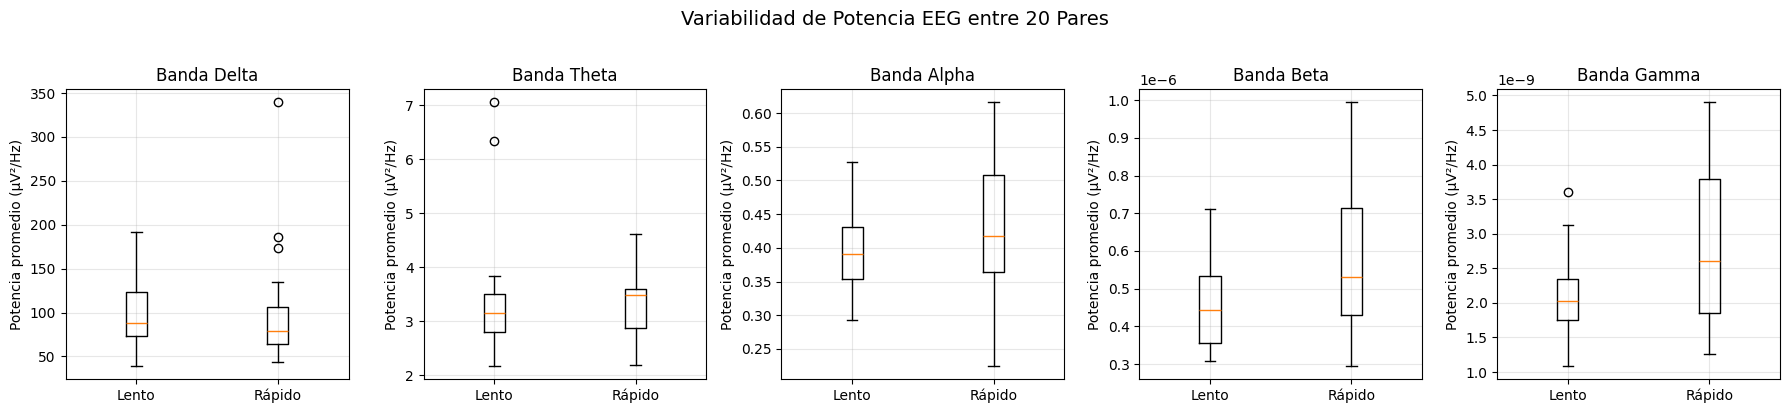


Análisis de 20 pares de audios (slow-fast)
Esto muestra cómo varía la respuesta cerebral entre diferentes contenidos de audio


In [8]:
# Calcular potencia promedio en bandas de frecuencia para múltiples pares
n_pares_analizar = 20
bandas_freq = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

resultados = {banda: {'slow': [], 'fast': []} for banda in bandas_freq.keys()}

for i in range(min(n_pares_analizar, len(slow_files), len(fast_files))):
    for condicion, archivos in [('slow', slow_files), ('fast', fast_files)]:
        data = loadmat(archivos[i])
        eeg = data["subeeg"]
        
        if eeg.shape[0] > eeg.shape[1]:
            eeg = eeg.T
        
        eeg_good = eeg[GOOD_ELECTRODES_PY, :]
        
        # Calcular PSD para el primer electrodo
        freqs, psd = signal.welch(eeg_good[0, :], fs=Fs_eeg, nperseg=min(2*Fs_eeg, eeg_good.shape[1]))
        
        # Calcular potencia en cada banda
        for banda, (f_min, f_max) in bandas_freq.items():
            mask = (freqs >= f_min) & (freqs <= f_max)
            potencia = np.mean(psd[mask])
            resultados[banda][condicion].append(potencia)

# Graficar comparación
fig, axes = plt.subplots(1, len(bandas_freq), figsize=(18, 4))

for idx, (banda, valores) in enumerate(resultados.items()):
    axes[idx].boxplot([valores['slow'], valores['fast']], labels=['Lento', 'Rápido'])
    axes[idx].set_title(f'Banda {banda}')
    axes[idx].set_ylabel('Potencia promedio (μV²/Hz)')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Variabilidad de Potencia EEG entre {n_pares_analizar} Pares', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nAnálisis de {n_pares_analizar} pares de audios (slow-fast)")
print("Esto muestra cómo varía la respuesta cerebral entre diferentes contenidos de audio")

### Hallazgos Clave:

1. **Estructura de Datos**:
   - Archivos contienen `subeeg` (EEG), `y` (audio), y `Fs` (frecuencia de muestreo)
   - 47 electrodos buenos de 65 totales
   - Frecuencia de muestreo EEG: ~250 Hz
   - Frecuencia de muestreo Audio: 44100 Hz

2. **Calidad de Datos**:
   - Sin valores NaN o Inf
   - Amplitudes en rango razonable
   - Estructura consistente entre archivos

3. **Características de las Condiciones**:
   - **Audio Lento**: Mismo contenido de audio a velocidad normal
   - **Audio Rápido**: Mismo contenido de audio acelerado
   - Las señales EEG capturan la respuesta cerebral a cada condición
   - Duraciones de grabación variables entre archivos

4. **Inventario de Archivos**:
   - Condición lenta: ~710 archivos
   - Condición rápida: ~706 archivos
   - Las grabaciones lentas son más largas (mismo audio a menor velocidad)

### Objetivo del Análisis:

Comparar la **conectividad cerebral** (señales EEG) entre las dos condiciones auditivas para identificar cómo el cerebro procesa audio a diferentes velocidades.

### Recomendaciones para Preprocesamiento:

1. **Bandas de Frecuencia EEG**:
   - Delta: 0.5-4 Hz
   - Theta: 4-8 Hz
   - Alpha: 8-13 Hz (banda prioritaria para atención)
   - Beta: 13-30 Hz
   - Gamma: 30-50 Hz

2. **Parámetros de Ventana Deslizante**:
   - Tamaño: 1-2 segundos
   - Solapamiento: 75%

3. **Diseño de Filtros**:
   - Filtros Butterworth pasabanda (orden 4-5)
   - Filtrado de fase cero (filtfilt)

4. **Organización de Datos**:
   - Procesar solo electrodos buenos (47 canales)
   - Manejar grabaciones de longitud variable
   - Mantener separación entre condiciones (slow/fast)

**Listo para proceder a Fase 1: Preprocesamiento**
